In [52]:
from scipy.ndimage import distance_transform_edt, binary_dilation
import tifffile
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2

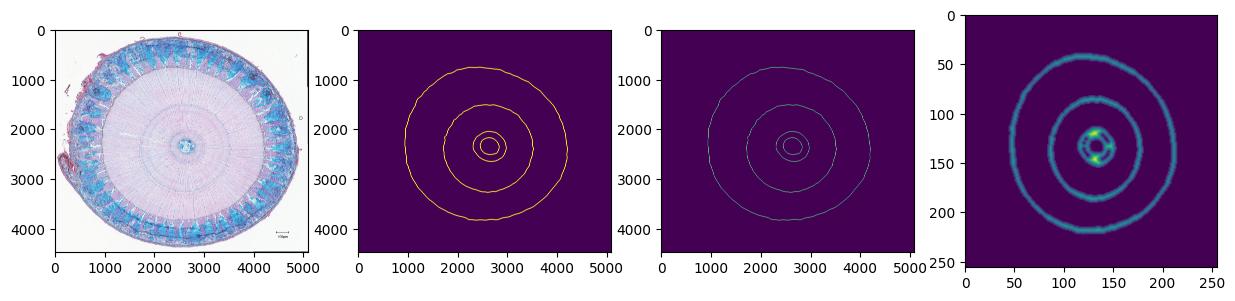

In [55]:
img = tifffile.imread('/home/khietdang/Documents/khiet/treeRing/input/4 E 4 t_8µm_x50.tif')
mask = tifffile.imread('/home/khietdang/Documents/khiet/treeRing/masks/4 E 4 t_8µm_x50.tif')
mask = mask / 255
mask = binary_dilation(mask, iterations=7)
dis = distance_transform_edt(mask)
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.subplot(1, 4, 2)
plt.imshow(mask)
plt.subplot(1, 4, 3)
plt.imshow(dis)
plt.subplot(1, 4, 4)
re = cv2.resize(re.astype(np.float32), (256, 256))
dis_re = distance_transform_edt(re)
plt.imshow(dis_re)

In [57]:
list_mask = glob.glob('/home/khietdang/Documents/khiet/treeRing/masks/*.tif')
for mask_path in list_mask:
    mask = tifffile.imread(mask_path)
    mask = mask / 255
    mask = binary_dilation(mask, iterations=10)
    dis = distance_transform_edt(mask).astype(np.float16)
    
    tifffile.imwrite(mask_path.replace('/masks/', '/big_dis/'), dis)

Tiling

In [58]:
import tensorflow as tf
import os
import cv2

In [59]:
input_folder = '/home/khietdang/Documents/khiet/treeRing/input/'
masks_folder = '/home/khietdang/Documents/khiet/treeRing/big_dis/'

In [60]:
def main():
    image_patches_folder = os.path.join(input_folder, "patches")
    mask_patches_folder = os.path.join(masks_folder, "patches")
    filterEmptyPatches(image_patches_folder, mask_patches_folder)  


def filterEmptyPatches(image_patches_folder, mask_patches_folder):
    masks = os.listdir(mask_patches_folder)
    mask_paths = [os.path.join(mask_patches_folder, file) for file in masks if file.endswith(".tif") or file.endswith(".jpg")]
    file_paths = [os.path.join(image_patches_folder, file) for file in masks if file.endswith(".tif") or file.endswith(".jpg")]
    fileNumber = 1
    for mask_path, file_path in zip(mask_paths, file_paths):
        print("\rProcessing file " + str(fileNumber) + " of " + str(len(mask_paths)) + "        ", end="")
        mask = tifffile.imread(mask_path)
        if np.sum(mask) == 0:
            os.remove(mask_path)
            os.remove(file_path)
            print("\rDeleting...                                                       ", end="")
        fileNumber = fileNumber + 1

# main()


In [61]:
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import cv2
import os

def main():
    exportPatches(input_folder)

def parse_with_opencv(image_path):
    return tifffile.imread(image_path.decode('UTF-8'))

def exportPatches(folder):
    out_folder = os.path.join(folder, "patches")
    os.makedirs(out_folder, exist_ok=True)
    files = os.listdir(folder)
    paths = [os.path.join(folder, file) for file in files if file.endswith(".tif") or file.endswith(".jpg")]
    ksize_rows = 256
    ksize_cols = 256
    strides_rows = 196
    strides_cols = 196
    # The size of sliding window
    ksizes = [1, ksize_rows, ksize_cols, 1] 
    # How far the centers of 2 consecutive patches are in the image
    strides = [1, strides_rows, strides_cols, 1]
    # The document is unclear. However, an intuitive example posted on StackOverflow illustrate its behaviour clearly. 
    # http://stackoverflow.com/questions/40731433/understanding-tf-extract-image-patches-for-extracting-patches-from-an-image
    rates = [1, 1, 1, 1] # sample pixel consecutively
    # padding algorithm to used
    padding='SAME' # or 'SAME'

    imageNumber = 1
    for img_path in paths:
        ds = tf.data.Dataset.from_tensor_slices([img_path]).map(
            lambda x: tf.numpy_function(parse_with_opencv, [x], Tout=tf.uint8)
        ) 
        image_patches = tf.image.extract_patches(images=list(ds), sizes=ksizes, strides=strides, rates=rates, padding=padding)
        columns = image_patches.shape[1]
        rows = image_patches.shape[2]    
        patchNumber = 1
        for col in range(columns):
            for row in range(rows):
                image_name, ext = os.path.splitext(img_path)
                image_name = os.path.basename(image_name)
                patch = image_patches[0,col,row,]
                patch = tf.reshape(patch, [ksize_rows, ksize_cols, 3])
                image_name = image_name + "_r" + str(row).zfill(4) + "_c" + str(col).zfill(4) + ext
                out_path = os.path.join(out_folder, image_name)
                print("\rsaving image nr.: " + str(imageNumber) + " of " + str(len(paths)) + ", patch nr.: " + str(patchNumber) + " of " + str(columns * rows) + "     ", end="")
                tifffile.imwrite(out_path, patch.numpy())               
                patchNumber = patchNumber + 1
        imageNumber = imageNumber + 1


main()


saving image nr.: 60 of 65, patch nr.: 625 of 625       

2025-03-11 15:52:45.034449: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


saving image nr.: 65 of 65, patch nr.: 1258 of 1258     

In [62]:
def main():
    exportPatches(masks_folder, type_= tf.float16)
    filterEmptyPatches(os.path.join(input_folder, "patches"), os.path.join(masks_folder, "patches"))

def parse_with_opencv(image_path):
    return tifffile.imread(image_path.decode('UTF-8'))[:, :, None]

def exportPatches(folder, type_):
    out_folder = os.path.join(folder, "patches")
    os.makedirs(out_folder, exist_ok=True)
    files = os.listdir(folder)
    paths = [os.path.join(folder, file) for file in files if file.endswith(".tif") or file.endswith(".jpg")]
    ksize_rows = 256
    ksize_cols = 256
    strides_rows = 196
    strides_cols = 196
    # The size of sliding window
    ksizes = [1, ksize_rows, ksize_cols, 1] 
    # How far the centers of 2 consecutive patches are in the image
    strides = [1, strides_rows, strides_cols, 1]
    # The document is unclear. However, an intuitive example posted on StackOverflow illustrate its behaviour clearly. 
    # http://stackoverflow.com/questions/40731433/understanding-tf-extract-image-patches-for-extracting-patches-from-an-image
    rates = [1, 1, 1, 1] # sample pixel consecutively
    # padding algorithm to used
    padding='SAME' # or 'SAME'

    imageNumber = 1
    for img_path in paths:
        ds = tf.data.Dataset.from_tensor_slices([img_path]).map(
            lambda x: tf.numpy_function(parse_with_opencv, [x], Tout=type_)
        ) 
        image_patches = tf.image.extract_patches(images=list(ds), sizes=ksizes, strides=strides, rates=rates, padding=padding)
        columns = image_patches.shape[1]
        rows = image_patches.shape[2]    
        patchNumber = 1
        for col in range(columns):
            for row in range(rows):
                image_name, ext = os.path.splitext(img_path)
                image_name = os.path.basename(image_name)
                patch = image_patches[0,col,row,]
                patch = tf.reshape(patch, [ksize_rows, ksize_cols, 1])
                image_name = image_name + "_r" + str(row).zfill(4) + "_c" + str(col).zfill(4) + ext
                out_path = os.path.join(out_folder, image_name)
                print("\rsaving image nr.: " + str(imageNumber) + " of " + str(len(paths)) + ", patch nr.: " + str(patchNumber) + " of " + str(columns * rows) + "     ", end="")
                tifffile.imwrite(out_path, patch.numpy())               
                patchNumber = patchNumber + 1
        imageNumber = imageNumber + 1


main()


Processing file 1075 of 60144                                     

/home/khietdang/anaconda3/envs/treering/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Processing file 60144 of 60144                                    

In [64]:
from sklearn.model_selection import train_test_split
import shutil

def filter_strings(strings, substring):
    return [s for s in strings if substring in s]

list_tile = glob.glob('/home/khietdang/Documents/khiet/treeRing/input/*.tif')
train, test = train_test_split(list_tile, test_size=0.2, shuffle=True, random_state=42)
list_tile = glob.glob('/home/khietdang/Documents/khiet/treeRing/input/patches/*.tif')

if os.path.exists('/home/khietdang/Documents/khiet/treeRing/tile_big_dis'):
    shutil.rmtree('/home/khietdang/Documents/khiet/treeRing/tile_big_dis')
os.makedirs('/home/khietdang/Documents/khiet/treeRing/tile_big_dis/train/x', exist_ok=True)
os.makedirs('/home/khietdang/Documents/khiet/treeRing/tile_big_dis/train/y', exist_ok=True)
os.makedirs('/home/khietdang/Documents/khiet/treeRing/tile_big_dis/test/x', exist_ok=True)
os.makedirs('/home/khietdang/Documents/khiet/treeRing/tile_big_dis/test/y', exist_ok=True)

for i in range(0, len(test)):
    test_name = os.path.basename(test[i])[:-4]
    tile_filtered = filter_strings(list_tile, test_name)

    for j in range(0, len(tile_filtered)):
        shutil.copy(tile_filtered[j], '/home/khietdang/Documents/khiet/treeRing/tile_big_dis/test/x' )
        shutil.copy(tile_filtered[j].replace('/input/', '/big_dis/'), '/home/khietdang/Documents/khiet/treeRing/tile_big_dis/test/y')

for i in range(0, len(train)):
    train_name = os.path.basename(train[i])[:-4]
    tile_filtered = filter_strings(list_tile, train_name)

    for j in range(0, len(tile_filtered)):
        shutil.copy(tile_filtered[j], '/home/khietdang/Documents/khiet/treeRing/tile_big_dis/train/x' )
        shutil.copy(tile_filtered[j].replace('/input/', '/big_dis/'), '/home/khietdang/Documents/khiet/treeRing/tile_big_dis/train/y')

    
